In the experiment estimating the effect of __Online Learning(Treatment)__ for __Exam score(Outcome)__, suppose the experiment is __randomised__, to estimate the treatment effect, we can use the following regression model.

$$exam_i = \beta_0 + \beta_1 Online_i + \mu_i$$

Where $\beta_0$ is a baseline, $\beta_1$ would be the treatment effect, and $Online_i = 1$ when it is online learning and 0 otherwise, $\mu_i$ is the other factors that can not be explained by $Online_i$ treatment.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr

In [2]:
url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/online_classroom.csv"
data = pd.read_csv(url).query("format_blended==0")
data.head()

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000
5,0,1.0,0.0,0.0,0.0,0.0,0.0,1,0.0,88.34996
7,1,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,90.00000


In [3]:
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


This nice form gives us the treatment effect $\beta_1 = -4.9122$ and the baseline $\beta_0 = 78.54$, and also a p-value and confidence interval for free.

In fact to derive the treatment effect can directly use the regression formula

$$\beta_1 = \frac{Cov(Y_i, T_i)}{Var(T_i)}$$

In [4]:
data['falsexam'].cov(data['format_ol'])/data['format_ol'].var()

-4.912221498226949

In fact, if we want to consider a multivariate regression with other variable, we should derive the same result

$$exam_i = \beta_0 + \beta_1 Online_i + \beta_2 X_0i + ... + \mu_i$$

And $\beta_1$ can be derived from

$$\beta_1 = \frac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}$$

Where $\tilde{T_i}$ is the residual when regress $X_0, X_1, ...$ on $T$. The intuition behind this is that if we can use $X$ to predict $T$, meaning the treatment is not random, so the residual $\tilde{T}$ is the part can not be explained by $X$. The treatment version of $\tilde{T_i}$ has nothing to do with any factors $X$.

However, if the experiment is not randomised, that is there are other factors can explain the outcome as well as the treatment, we can include other factors in the regression formula as above. __And the $\beta$ of treatment we get would be equivalent to the treatment effect with all other factors controlled.__

In [5]:
# The two methods produces the same result
reg1 = smf.ols("format_ol ~ gender", data=data).fit()
reg1.summary().tables[1]

data['resid'] = reg1.resid
beta1 = data['falsexam'].cov(data['resid'])/data['resid'].var()

print("beta estimate from residual:", beta1)

result = smf.ols("falsexam ~ format_ol + gender", data=data).fit()
result.summary().tables[1]

beta estimate from residual: -4.505333132264121


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,75.7088,1.529,49.528,0.000,72.695,78.722
format_ol,-4.5053,1.663,-2.709,0.007,-7.783,-1.227
gender,4.4821,1.680,2.668,0.008,1.170,7.794


In [6]:
data['falsexam'].cov(data['gender'])/data['gender'].var()

4.899675237578061

## Confounding Bias

When omit the confounding factors $X$, the estimated treatment effect is biased, as it includes the effect of the confounding component.

$$\frac{Cov(Y_i, T_i)}{Var(T_i)} = \beta_1 + \beta^{\prime}\delta$$

Where $\delta$ is the coefficient of regressing confounding factors on the treatment, and $\beta^{\prime}$ is the coeffient term of regressing $X$ on $Y$, which is the bias term. This bias term becomes 0 in two cases:

1. __If the variables $X$ does not explain $Y$__. Intuitively understanding, the treatment effect would not be biased if other variables included are totally irrelevant to the outcome.

2. __If the variables $X$ deos not explain $T$__. This means the treatment is randomly assigned, as the assignment can not be explained by any other variables.

__If one of them safice, the bias term is going to be 0__, e.g. if $X$ affects $T$ but not $Y$, them the $\delta$ would be 0, and the bias would be 0.

But still, even with $X$ included in the regression, we can not conclude that the final treatment effect is unbiased, as there still can be other factors that we don't know but are confounders to the experiment.


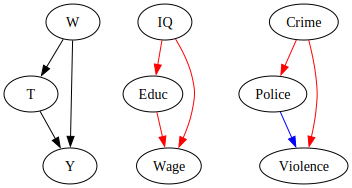

In [7]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"), 
g.edge("Police", "Violence", color="blue")

g

In this two examples, __IQ__ and __Crime__ are the confounders. as IQ can lead to more years of education as well as higer wage, if we don't control IQ, the treatment effect of education would be higher than it should be.

In the second example, Crime leads to more police as well as higher violence rate, if we don't see Crime, we would observe more police causes more violence. Only if we control the crime, can we know that it is actually suppress violence.

> __The source of omitted variable bias is confounding: a variable that affects both the treatment and the outcome.__